In [2]:
from skimage.util import img_as_ubyte
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import cv2
import os
import numpy as np
from skimage import io
from skimage.filters import threshold_otsu
from skimage.segmentation import  flood_fill
from skimage.feature import peak_local_max
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from skimage.filters import sobel
from skimage.morphology import skeletonize
from skimage.measure import find_contours
from skimage.draw import rectangle
import math
from matplotlib.pyplot import bar
import matplotlib.pyplot as plt

# Show the figures / plots inside the notebook
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 



In [3]:
def auto_crop(binary_image: np.ndarray) -> np.ndarray:
    all_points = cv2.findNonZero(binary_image)
    x, y, w, h = cv2.boundingRect(all_points)
    height, width = binary_image.shape
    border = 0
    left = max(0, x - border)
    right = min(width, x + w + border)
    top = max(0, y - border)
    bottom = min(height, y + h + border)
    return binary_image[top:bottom, left:right], top, bottom


In [20]:
######## return hog features from input image #########
def extract_hog_features(img):
    img = cv2.resize(img, (110, 200))
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
    return fd

In [21]:
####### return hog features from arr of images ###########
def feature_extraction_hog(images):
    feature = []
    for img in images:
        img = img.astype('uint8')
        img = cv2.resize(img, (64, 64), cv2.INTER_AREA)
        featuresHog = extract_hog_features(img.astype('uint8'))
        feature.append(featuresHog)
    return feature

In [22]:
######## binarize image ##########
def local_binarize(img, block_size = 35, offset_val = 10):
    img=img_as_ubyte(img)
    b_img= img < threshold_otsu(img)
    return b_img    

In [23]:
####### function that returns the row of the text basline #######
def baseline(img):
    horizontal_projection = np.sum(img, axis=1)
    return np.argmax(horizontal_projection)

In [24]:
###### function that takes the folder of the dataset then returns array of images and their labels ########
def load_images_from_folder(folders):
    images = []
    y=[]
    i = 1
    for folder in folders:   
        for filename in os.listdir(folder):
            img = io.imread(os.path.join(folder,filename), 1)
            if img is not None:
                b_img=local_binarize(img)
                baseline_i=baseline(b_img)
                if np.sum(b_img[baseline_i])>=(b_img.shape[1]-2):
                #     # print("width",((3*b_img.shape[1])/4))
                #     # print("sum: ",sum(b_img[0]))
                    b_img= 1-b_img
                # show_images([b_img],['image'])
                    
                
                images.append(b_img)
                
                y.append(i)
        i+=1
    return images, y

In [25]:
############### function that extracts hog features from dataset ###################
def process_Hog():    
    features = feature_extraction_hog(images)
    return features, y

In [104]:
import glob
x=[]
# x = glob.glob("F:\\Downloads\\\ACdata_base\\1\\*")
# x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\2\\*"))
x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\3\\*"))
# x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\4\\*"))
x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\5\\*"))
# x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\6\\*"))
# x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\7\\*"))
x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\8\\*"))
x.extend(glob.glob("F:\\Downloads\\\ACdata_base\\9\\*"))
images, y = load_images_from_folder(["F:\Downloads\ACdata_base\\5","F:\Downloads\ACdata_base\\8","F:\Downloads\ACdata_base\\9", "F:\Downloads\ACdata_base\\3"])
# images, y = load_images_from_folder(["F:\\Downloads\\\ACdata_base\\1","F:\\Downloads\\\ACdata_base\\2","F:\\Downloads\\\ACdata_base\\3","F:\\Downloads\\\ACdata_base\\4","F:\\Downloads\\\ACdata_base\\5","F:\\Downloads\\\ACdata_base\\6","F:\\Downloads\\\ACdata_base\\7","F:\\Downloads\\\ACdata_base\\8","F:\\Downloads\\\ACdata_base\\9"])
# images, y = load_images_from_folder(["F:\\Downloads\\\ACdata_base\\1"])


In [66]:
######### Horizontal profile projection ###########
def HPP(img):
    horizontal_projection = np.sum(img, axis=1)
    # horizontal_projection=peak_local_max(horizontal_projection, min_distance=3).size
    return np.histogram(horizontal_projection, bins=10)[0]


In [67]:
def count_contour(img,minArea):
    find_contour_img=find_contours(img,0.5)
    i=0
    vertical_lines_height = []
    max_height = 0.0001
    variance=0
    for box in find_contour_img:  
        Xmin=min(box[:,1])
        Xmax=max(box[:,1])
        Ymin=min(box[:,0])
        Ymax=max(box[:,0])
        if (Ymax-Ymin)*(Xmax-Xmin)>minArea:
            vertical_lines_height.append(Ymax-Ymin)
            i+=1
    if vertical_lines_height != []:
        max_height=max(vertical_lines_height)
        variance=np.var(vertical_lines_height)
    return i, max_height, variance

In [68]:
def count_contours_full(img,minArea):
    # find contours for symbols
    img=img.astype('uint8')
    find_contour_img=find_contours(img,0.8)
    # print([find_contour_img],["find contour"])
    final= np.zeros(img.shape)
    # iterate on shapes
    i=0
    a=[]
    for box in find_contour_img:  
        Xmin=min(box[:,1])
        Xmax=max(box[:,1])
        Ymin=min(box[:,0])
        Ymax=max(box[:,0])
        if (Ymax-Ymin)*(Xmax-Xmin)>minArea:
            rr, cc = rectangle(start = (math.ceil(0),math.ceil(Xmin)), end = (math.ceil(img.shape[0]),math.ceil(Xmax)), shape=img.shape)
            final[rr,cc]=1
            i+=1
            a.append([[Ymax,Xmax],[Ymax,Xmin],[Ymin,Xmin],[Ymin,Xmax]])

    return i,a

In [69]:
def black_white_ratio(b_img):
    white=np.sum(b_img==1)
    black=np.sum(b_img==0)
    # print("black:",black)
    temp=[]
    if (black==0):
        temp.append(0)
        return temp
    temp.append(white/black )
    return  temp  


In [70]:
def black_white_ratio_up(b_img):
    baseline_i=baseline(b_img)
    white=np.sum(b_img[0:baseline_i,:]==1)
    black=np.sum(b_img[0:baseline_i,:]==0)
    # print("blu: ",baseline_i)
    # print("blackup:",black)
    # show_images([b_img],['hehe'])
    temp=[]
    if (black==0):
        temp.append(0)
        return temp
    temp.append(white/black )
    return  temp

In [71]:

def black_white_ratio_down(b_img):
    baseline_i=baseline(b_img)
    white=np.sum(b_img[baseline_i:,:]==1)
    black=np.sum(b_img[baseline_i:,:]==0)
    # print("bld: ",baseline_i)
    temp=[]
    if (black==0):
        temp.append(0)
        return temp
    temp.append(white/black )
    return  temp 

In [72]:
def density_up(b_img,min_area):
    baseline_i=baseline(b_img)
    temp=[]
    if baseline_i<=2:
        temp.append(0)
        # show_images([b_img],['mmm'])
        return temp 
    # print("baseline",baseline_i)
    y,_=count_contours_full(b_img,min_area)
    x,_=count_contours_full(b_img[0:baseline_i,:],min_area)
    
    temp.append(x/y)
    return temp

In [83]:
def density_down(b_img,min_area):
    baseline_i=baseline(b_img)
    temp=[]
    if baseline_i>=b_img.shape[0]-5:
        # show_images([b_img],['nn'])
        temp.append(0)
        return temp 
    y,_=count_contours_full(b_img,min_area)
    x,_=count_contours_full(b_img[baseline_i:,:],min_area)
    
    temp.append(x/y)
    return temp
    

In [4]:
def min_rect(img):
    rotations=[]
    contours = cv2.findContours(img.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] 
    for j,contour in enumerate(contours):
            box = cv2.minAreaRect(contour)
            rotations.append(box[2])
        
    avg_angle=sum(rotations)/len(rotations) 
    return avg_angle

In [85]:
######### takes binary image and returns skeleton, edge, text-only, diacretecs image
def processing_images(binary_img):
    bw_img=binary_img
    baseline_i=baseline(bw_img)
    seeds=[]
    for j in range(bw_img.shape[1]-1):
        if(bw_img[baseline_i][j]==False and bw_img[baseline_i][j+1]==True):
            seeds.append(j+1)
    diacritics = bw_img
    for j in seeds:
        diacritics = flood_fill(diacritics, (baseline_i, j), False)
    text_only = bw_img != diacritics
    sobel_img = sobel(bw_img)
    skeletonized_img=skeletonize(bw_img)
    
    return sobel_img, skeletonized_img, diacritics, text_only

In [86]:
####### function that returns num of horizontal and vertical lines
def HVSL(bw_image):
    # hough line to detect lines in the photo
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 2)
    h, theta, d = hough_line(bw_image, theta=tested_angles)
    origin = np.array((0, bw_image.shape[1]))
    # hough peaks to get those lines
    angles=[]
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        angles.append(angle)
    angles = [angle * 180 / np.pi for angle in angles]
    return angles.count(90.0), angles.count(180.0)



In [87]:
################### 1st feature ##################
def HVSL_features(edge):
    vertical_lines, horizontal_lines = HVSL(edge)
    if(vertical_lines+horizontal_lines) == 0:
        horizontal_lines=.0001
    ratio_pixels_HVL = np.count_nonzero(edge)/(vertical_lines + horizontal_lines)
    return vertical_lines, horizontal_lines, ratio_pixels_HVL
    

In [88]:
def text_HVSL_feature(edge):
    edge = img_as_ubyte(edge)
    fld = cv2.ximgproc.createFastLineDetector()
    lines = fld.detect(edge)
    
    vertical_lines = (lines[:,0,0] == lines[:,0,2]).sum()
    horizontal_lines = (lines[:,0,1] == lines[:,0,3]).sum()
    if(vertical_lines+horizontal_lines) == 0:
        horizontal_lines=.0001
    freq_appearance_ratio = (vertical_lines+horizontal_lines)/len(lines)
    ratio_pixels_HVL = np.count_nonzero(edge)/freq_appearance_ratio
    return freq_appearance_ratio, ratio_pixels_HVL


In [89]:
def text_height_feature(skeleton):
    skeleton = img_as_ubyte(skeleton)
    kernel_vertical_line=np.ones((3,1))
    line = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel_vertical_line)
    line=line/255
    num_of_verticle_lines, max_vertical_line_height, variance = count_contour(line,3*1)

    start_height=0
    end_height=0
    for i in range(line.shape[0]):
        if(np.any((line[i] == 1))):
            start_height = i
            break
    for i in range(line.shape[0]-1, 0, -1):
        if(np.any((line[i] == 1))):
            end_height = i
            break
    text_height = abs(start_height-end_height)
    return text_height, num_of_verticle_lines, max_vertical_line_height, text_height/max_vertical_line_height , variance



In [90]:
def text_thickness(edge_img, skeleton_img):
    row = min (skeleton_img.shape[0], edge_img.shape[0])
    col = min (skeleton_img.shape[1], edge_img.shape[1])
    dist = []
    left = 0
    right = 0
    l = False
    r = False
    for i in range (row-1):
        for j in range (col-1):
            l = False
            r = False
            if skeleton_img[i][j] == 1:
                max1 = max(j-10,0)
                min2 = min(j+10,col)
                for k in range(j,max1,-1):
                    if edge_img[i][k] > 0:
                        left = k
                        l = True
                        break
                for g in range(j,min2):
                    if edge_img[i][g] > 0:
                        right = g
                        r = True
                        break
                if l == False:
                    left = j
                if r == False:
                    right = j
                dist.append(abs(right-left))
    h = np.histogram(dist)
    return h[0]


In [113]:
def process_LVL_HVSL():
    featuresLVL =[]
    featuresHVSL=[]
    HPP_features=[]
    featuresToE=[]
    featuresToS=[]
    featuresThickness=[]
    HOG=[]
    black_white=[]
    black_white_up=[]
    black_white_down=[]
    d_up=[]
    d_down=[]
    m_rect=[]
    for index,path in enumerate(x):
        img = io.imread(path, 1)
        HOG.append(extract_hog_features(img))
        bw_img=local_binarize(img)
        # baseline_i=baseline(bw_img)
        # if np.sum(bw_img[baseline_i])>=(bw_img.shape[1]-2):
        #     bw_img= 1-bw_img
        edge, skeleton, diacritics, text_only = processing_images(bw_img)
        show_images([bw_img],["edge"])
        featuresLVL.append(text_height_feature(skeleton))
        #featuresHVSL.append(text_HVSL_feature(edge))
        HPP_features.append(HPP(bw_img))
        featuresThickness.append(text_thickness(edge, skeleton))
        skeleton = img_as_ubyte(skeleton)
        edge = img_as_ubyte(edge)
        featuresToS.append(extract_hog_features(skeleton))
        featuresToE.append(extract_hog_features(edge))
        black_white.append(black_white_ratio(images[index]))
        black_white_up.append(black_white_ratio_up(images[index]))
        black_white_down.append(black_white_ratio_down(images[index]))
        d_up.append(density_up(images[index],3))
        d_down.append(density_down(images[index],3))
        m_rect.append([min_rect(images[index])])
    bw=np.histogram(black_white)
    bw_up=np.histogram(black_white_up)
    bw_down=np.histogram(black_white_down)
    # return 
    return featuresLVL, HPP_features, featuresToS, featuresToE,featuresThickness, HOG,black_white,black_white_up,black_white_down,d_up,d_down,m_rect,y


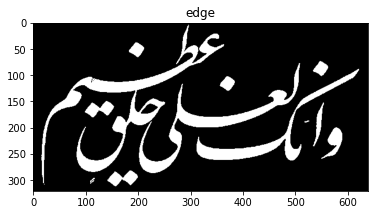

TypeError: 'int' object is not callable

In [114]:
################ demo test for LVL extraction from dataset using Decision Trees
featuresLVL, HPP_features, featuresToS, featuresToE,featuresThickness, HOG,black_white,black_white_up,black_white_down,d_up,d_down,m_rect,y = process_LVL_HVSL()
################ demo test for hog extraction from dataset using support vector machine
X_train, X_test, y_train, y_test = model_selection.train_test_split(HPP_features, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly = svm.SVC(kernel='rbf', degree=3, C=5).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))




In [ ]:
X = np.hstack((featuresLVL, HPP_features, featuresToE, featuresThickness,HOG,black_white,black_white_up,black_white_up,d_up,m_rect))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly =  RandomForestClassifier(max_depth=20, random_state=0).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


F1 (Polynomial Kernel):  100.00


In [ ]:
# ARR=[XLVL, XHVSL, HPP_features, featuresToE, featuresThickness,HOG,bw,bw_up,d_up,m_rect]
# ARR2=[XLVL, XHVSL, HPP_features, featuresToE, featuresThickness,HOG,bw,bw_up,d_up,m_rect]

    
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly =  RandomForestClassifier(max_depth=20, random_state=0).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))

F1 (Polynomial Kernel):  100.00


In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(featuresToE, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
poly = svm.SVC(kernel='rbf', degree=3, C=5).fit(X_train, y_train)
poly_pred = poly.predict(X_test)
poly_accuracy = accuracy_score(y_test, poly_pred)
poly_f1 = f1_score(y_test, poly_pred, average='weighted')
print('Accuracy (Polynomial Kernel): ', "%.2f" % (poly_accuracy*100))
print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100))


Accuracy (Polynomial Kernel):  97.39
F1 (Polynomial Kernel):  97.39


In [ ]:
min = 0
features=[]
index=[]
for i in range(len(ARR2)-1):
    ARR=ARR2.copy()
    del ARR[i]
    a_new= ARR
    X = np.hstack(tuple(a_new))
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
    poly =  RandomForestClassifier(max_depth=20, random_state=0).fit(X_train, y_train)
    poly_pred = poly.predict(X_test)
    poly_f1 = f1_score(y_test, poly_pred, average='weighted')
    print('F1 (Polynomial Kernel): ', "%.2f" % (poly_f1*100), i)

    if(poly_f1> min):
        min = poly_f1
        features = X
        index = [i]
        print(i)
print(index, min, features)

NameError: name 'ARR2' is not defined

In [ ]:
# ################# demo test for HVSL extraction from dataset using Decision Trees
# X, y = process_HVSL()
# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
# clf = DecisionTreeClassifier().fit(X_train, y_train)
# clf_pred = clf.predict(X_test)
# clf_accuracy = accuracy_score(y_test, clf_pred)
# clf_f1 = f1_score(y_test, clf_pred, average='weighted')
# print('Accuracy (Polynomial Kernel): ', "%.2f" % (clf_accuracy*100))
# print('F1 (Polynomial Kernel): ', "%.2f" % (clf_f1*100))



In [ ]:
# import arabic_reshaper
# from bidi.algorithm import get_display
# import PIL.Image, PIL.ImageFont, PIL.ImageDraw
# import pyquran as q
# from config import arabic_reshaper_config
# import re 
# import requests
# import numpy as np
# import cv2
# def remove_Quranic_stops(text: str) -> str:
#     Quranic_stops = re.compile(
#         '['
#         '\u06d6-\u06ef'
#         ']',

#         re.UNICODE | re.X
#     )

#     return re.sub(Quranic_stops, "", text)

# def remove_tashkeel(text: str) -> str:
#     HARAKAT_RE = re.compile(
#         '['
#         '\u0610-\u061a'
#         '\u064b-\u065f'
#         '\u0670'
#         '\u06d6-\u06dc'
#         '\u06df-\u06e8'
#         '\u06ea-\u06ed'
#         '\u08d4-\u08e1'
#         '\u08d4-\u08ed'
#         '\u08e3-\u08ff'
#         ']',

#         re.UNICODE | re.X
#     )

#     return re.sub(HARAKAT_RE, "", text)

# def binarize(img: np.ndarray) -> np.ndarray:
#     threshold, output_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

#     avg_corners = np.average([*output_img[0, :], *output_img[-1, :], *output_img[:, 0], *output_img[:, -1]])

#     if avg_corners > (255 / 2) and cv2.countNonZero(output_img) / img.size >= 0.5:
#         output_img = 255 - output_img

#     return output_img


# def auto_crop(binary_image: np.ndarray) -> np.ndarray:
#     all_points = cv2.findNonZero(binary_image)
#     x, y, w, h = cv2.boundingRect(all_points)

#     height, width = binary_image.shape

#     border = 50
#     left = max(0, x - border)
#     right = min(width, x + w + border)
#     top = max(0, y - border)
#     bottom = min(height, y + h + border)

#     return binary_image[top:bottom, left:right]


# def preprocess(img: np.ndarray) -> np.ndarray:
#     img = binarize(img)
#     img = auto_crop(img)
#     return img


# i = 0
# reshaper = arabic_reshaper.ArabicReshaper(configuration=arabic_reshaper_config)
# for surah in range(50, 115):
#     surah = str(surah).zfill(3)
#     text = requests.get(f"https://www.quranful.com/text/ar-allah/{surah}.txt").text

#     for aya_index, aya in enumerate(text.split('\n')):
#         if len(aya) >= 50 or aya.strip() == '':
#             continue

#         for font_name in ["parsi"]:
#             if font_name in ["parsi"]:
#                 text_to_be_reshaped = remove_tashkeel(text_to_be_reshaped)
#             text_to_be_reshaped = remove_Quranic_stops(aya)
#             reshaped_text = reshaper.reshape(text_to_be_reshaped)

#             rev_text = reshaped_text[::-1]  # slice backwards

#             font = PIL.ImageFont.truetype(f"{font_name}.ttf", 100)
#             img = PIL.Image.new("L", (2500, 400), color=0)
#             draw = PIL.ImageDraw.Draw(img)

#             draw.text((50, 50), rev_text, fill=255, font=font)
#             draw = PIL.ImageDraw.Draw(img)

#             img = preprocess(np.array(img))
#             cv2.imwrite("parsi/image"+str(i)+".jpg", img)
#             i+=1






TypeError: 'int' object is not callable

In [ ]:
# def process_HVSL():
#     features =[]
#     for path in x:
#         img = io.imread(path, 1)
#         bw_img=local_binarize(img)
#         edge, skeleton, diacritics, text_only=processing_images(bw_img)
#     return features, y

In [ ]:
import numpy as np
print(len(y_test), "test")
y_test = np.array(y_val)
for i in np.unique(y_test):
    class1 = np.where(y_test==i)[0]
    print("class"+str(i))
    acc = sum(i == poly_pred[class1])/len(class1)
    print(acc, i)

import numpy as np
print(len(y_test), "test")
y_test = np.array(y_test)
for i in [3,6]:
    class1 = np.where(y_test==i)[0]
    print("class"+str(i), poly_pred[class1])
    acc = sum(i == poly_pred[class1])/len(class1)
    print(acc, i)


337 test
class1
0.10256410256410256 1
class2
0.1282051282051282 2
class3
0.11428571428571428 3
class4
0.14285714285714285 4
class5
0.14634146341463414 5
class6
0.15384615384615385 6
class7
0.13953488372093023 7
class8
0.07142857142857142 8
class9
0.06666666666666667 9
337 test
class3 [4 2 5 1 3 8 3 1 7 1 7 4 6 2 7 8 3 9 1 1 9 8 2 5 3 8 1 7 2 5 8 4 2 4 8]
0.11428571428571428 3
class6 [6 6 4 3 9 9 4 8 2 4 4 5 9 9 6 4 4 8 9 5 6 8 2 9 1 1 7 9 5 5 7 2 6 8 3 7 3
 6 9]
0.15384615384615385 6
